In [1]:
import scanpy as sc
from pathlib import Path
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp
import decoupler

import os
import sys
import logging
import warnings
from utils import *

/ocean/projects/cis240075p/asachan/.conda/envs/decoupler/lib/python3.12/site-packages/scanpy/_utils/__init__.py:27: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/ocean/projects/cis240075p/asachan/.conda/envs/decoupler/lib/python3.12/site-packages/scanpy/__init__.py:36: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/ocean/projects/cis240075p/asachan/.conda/envs/decoupler/lib/python3.12/site-packages/scanpy/readwrite.py:15: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [18]:
def plot_pathway_dotplot(
    df_cell_level,
    score_cols,  # List of pathway score column names (y-axis)
    sample_col='sample',  # Column name for sample IDs (x-axis)
    annotation_col='Annotation',
    target_annotation=None,
    sample_order=None,  # Optional: list of samples in desired order
    figsize=(10, 6),
    min_dot_size=20,
    max_dot_size=500,
    dot_size_scale_factor=1.0,
    cmap_name="coolwarm",
    value_legend_title="Mean Score",
    size_legend_title="# Cells",
    ylabel="Pathways",
    xlabel="Samples"
):
    """
    Plots a dot plot where dot color is mean pathway score and dot size is number of cells.
    
    Parameters:
        df_cell_level (pd.DataFrame): Cell-level data with scores, sample, annotation.
        score_cols (list): List of score column names (pathways) - will be y-axis.
        sample_col (str): Column name for sample IDs - will be x-axis.
        annotation_col (str): Column name for annotations.
        target_annotation (str or None): If provided, subset to this annotation.
        sample_order (list or None): Order of samples for x-axis. If None, uses sorted order.
        figsize (tuple): Figure size.
        min_dot_size (int): Minimum size for dots.
        max_dot_size (int): Maximum size for dots.
        dot_size_scale_factor (float): Multiplier for raw cell counts before scaling to dot size.
        cmap_name (str): Colormap for the scores.
        value_legend_title (str): Title for the colorbar.
        size_legend_title (str): Title for the size legend.
        ylabel (str): Label for y-axis (pathways).
        xlabel (str): Label for x-axis (samples).
    """
    plot_df = df_cell_level.copy()

    # 1. Filter by annotation if specified
    if target_annotation is not None:
        if annotation_col not in plot_df.columns:
            print(f"Warning: Annotation column '{annotation_col}' not found. Cannot filter by '{target_annotation}'.")
            return
        plot_df = plot_df[plot_df[annotation_col] == target_annotation]
        if plot_df.empty:
            print(f"No cells found for annotation '{target_annotation}'.")
            return

    # Check required columns
    required_cols = [sample_col] + score_cols
    for col in required_cols:
        if col not in plot_df.columns:
            print(f"Warning: Required column '{col}' not found. Aborting.")
            return

    plot_df = plot_df.dropna(subset=[sample_col], how='any')
    if plot_df.empty:
        print("No data to plot after initial NaN filtering.")
        return

    # 2. Aggregate: mean scores and cell counts per sample
    grouped = plot_df.groupby(sample_col)
    mean_scores_df = grouped[score_cols].mean()
    cell_counts_series = grouped.size()

    # 3. Determine sample order
    if sample_order is None:
        ordered_samples = sorted(mean_scores_df.index.tolist())
    else:
        # Use provided order, but only include samples that exist in data
        ordered_samples = [s for s in sample_order if s in mean_scores_df.index]
        if not ordered_samples:
            print("None of the specified samples found in data.")
            return

    # 4. Prepare data for plotting (long format)
    plot_data_list = []
    for sample_id in ordered_samples:
        for pathway in score_cols:
            mean_score = mean_scores_df.loc[sample_id, pathway] if sample_id in mean_scores_df.index else np.nan
            cell_count = cell_counts_series.loc[sample_id] if sample_id in cell_counts_series.index else 0
            plot_data_list.append({
                'sample': sample_id,
                'pathway': pathway,
                'mean_score': mean_score,
                'cell_count': cell_count
            })
    
    plot_data_df = pd.DataFrame(plot_data_list)
    plot_data_df = plot_data_df.dropna(subset=['mean_score'])

    if plot_data_df.empty:
        print("No data to plot after aggregation.")
        return

    # 5. Scale cell counts for dot sizes
    min_count = plot_data_df['cell_count'].min()
    max_count = plot_data_df['cell_count'].max()
    
    if max_count == min_count:
        plot_data_df['dot_size'] = min_dot_size if max_count == 0 else (min_dot_size + max_dot_size) / 2
    else:
        scaled_counts = plot_data_df['cell_count'] * dot_size_scale_factor
        min_s_count = scaled_counts.min()
        max_s_count = scaled_counts.max()
        
        if max_s_count == min_s_count:
            plot_data_df['dot_size'] = min_dot_size if max_s_count == 0 else (min_dot_size + max_dot_size) / 2
        else:
            plot_data_df['dot_size'] = min_dot_size + \
                (scaled_counts - min_s_count) / (max_s_count - min_s_count) * (max_dot_size - min_dot_size)

    # 6. Plotting
    fig, ax = plt.subplots(figsize=figsize)

    # Create coordinate mappings
    pathway_y_coords = {name: i for i, name in enumerate(score_cols)}
    sample_x_coords = {name: i for i, name in enumerate(ordered_samples)}

    scatter = ax.scatter(
        x=plot_data_df['sample'].map(sample_x_coords),
        y=plot_data_df['pathway'].map(pathway_y_coords),
        s=plot_data_df['dot_size'],
        c=plot_data_df['mean_score'],
        cmap=cmap_name,
        edgecolors='gray',
        linewidths=0.5
    )

    # X-axis (Samples)
    ax.set_xticks(list(sample_x_coords.values()))
    ax.set_xticklabels(ordered_samples, rotation=45, ha="right")
    ax.set_xlabel(xlabel)

    # Y-axis (Pathways)
    ax.set_yticks(list(pathway_y_coords.values()))
    ax.set_yticklabels(score_cols)
    ax.set_ylabel(ylabel)

    # Colorbar for Mean Score
    cbar = fig.colorbar(scatter, ax=ax, fraction=0.03, pad=0.15)
    cbar.set_label(value_legend_title)

    # Legend for Dot Size (# Cells)
    if max_count > 0:
        legend_counts_raw = np.linspace(min_count, max_count, num=4, dtype=int)
        if min_count == 0 and 0 not in legend_counts_raw and len(legend_counts_raw) > 1:
            legend_counts_raw[0] = 0
        legend_counts_raw = np.unique(legend_counts_raw)
    else:
        legend_counts_raw = np.array([min_count]) if min_count > 0 else np.array([0])

    legend_dots = []
    for count_val in legend_counts_raw:
        if max_count == min_count:
            size_val = min_dot_size if max_count == 0 else (min_dot_size + max_dot_size) / 2
        else:
            scaled_c = count_val * dot_size_scale_factor
            size_val = min_dot_size + \
                (scaled_c - (min_count * dot_size_scale_factor)) / \
                ((max_count * dot_size_scale_factor) - (min_count * dot_size_scale_factor)) * \
                (max_dot_size - min_dot_size)
        size_val = max(min_dot_size, min(max_dot_size, size_val))
        legend_dots.append(plt.scatter([], [], s=size_val, c='gray', label=f"{int(count_val)}"))

    size_leg = ax.legend(
        handles=legend_dots,
        title=size_legend_title,
        bbox_to_anchor=(1.18, 0.4),
        loc='center left',
        labelspacing=1.5,
        borderpad=1,
        frameon=True,
        handletextpad=1.5,
        scatterpoints=1
    )

    # Layout adjustments
    fig_title = f'Pathway Activity Dot Plot (Annotation: {target_annotation})' if target_annotation else 'Pathway Activity Dot Plot'
    plt.suptitle(fig_title, fontsize=16, y=1.02)
    plt.subplots_adjust(bottom=0.15, right=0.8)
    plt.grid(True, linestyle='--', alpha=0.3, axis='both')
    ax.tick_params(axis='both', which='major', pad=7)

    plt.tight_layout()
    plt.show()

In [2]:
adata_female_file = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/female_98_80.h5ad'
adata_male_file = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/male_98_85.h5ad'
#adata_with_features_file = 
adata_female = sc.read_h5ad(adata_female_file)
adata_male = sc.read_h5ad(adata_male_file)

In [3]:
def convert_genes(gene_list, direction='human_to_mouse'):
    """
    Convert gene symbols between human and mouse formats.
    """
    direction = direction.lower()
    
    if direction in ['human_to_mouse', 'h2m']:
        # Human to mouse: capitalize (first letter uppercase, rest lowercase)
        return [gene.capitalize() for gene in gene_list]
    
    elif direction in ['mouse_to_human', 'm2h']:
        # Mouse to human: all uppercase
        return [gene.upper() for gene in gene_list]
    
    else:
        raise ValueError(
            f"Invalid direction: {direction}. "
            "Use 'human_to_mouse'/'h2m' or 'mouse_to_human'/'m2h'"
        )

In [4]:
custom_atrophy_pathway = ["UBB","UBC","FBXO32","TRIM63","MDM2","FBXO30","CAMK2B","TIE1","PSMA1","PSMA2","PSMA3","PSMA4","PSMA5","PSMA6","PSMA7","PSMB1","PSMB2","PSMB3","PSMB4","FBXO21","FBXO31","NEDD4","UBE2B","UBE2G1","UBE2J1","CTSL","CTSV","BNIP3","DEPP1","GABARAPL1","MAP1LC3","RETREG1","SQSTM1","CAPN1","CAPN2","ATF4","FOXO1","FOXO3A","HDAC9","RUNX1","AMPD3","CHRNA1","CDKN1A"]
# Convert to mouse gene format
custom_atrophy_pathway_mouse = convert_genes(custom_atrophy_pathway, 'human_to_mouse')
print(custom_atrophy_pathway_mouse)

['Ubb', 'Ubc', 'Fbxo32', 'Trim63', 'Mdm2', 'Fbxo30', 'Camk2b', 'Tie1', 'Psma1', 'Psma2', 'Psma3', 'Psma4', 'Psma5', 'Psma6', 'Psma7', 'Psmb1', 'Psmb2', 'Psmb3', 'Psmb4', 'Fbxo21', 'Fbxo31', 'Nedd4', 'Ube2b', 'Ube2g1', 'Ube2j1', 'Ctsl', 'Ctsv', 'Bnip3', 'Depp1', 'Gabarapl1', 'Map1lc3', 'Retreg1', 'Sqstm1', 'Capn1', 'Capn2', 'Atf4', 'Foxo1', 'Foxo3a', 'Hdac9', 'Runx1', 'Ampd3', 'Chrna1', 'Cdkn1a']


## Geneset (atrophy/senescence) scores

In [56]:
sensig_geneset_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/mouse/SenSig_DEGs.csv'
fridman_down_orthologs_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/mouse/fridman_down_orthologs.csv'
fridman_up_orthologs_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/mouse/fridman_up_orthologs.csv'
senmayo_geneset_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/mouse/SAUL_SEN_MAYO_UP_IN_SEN.v2024.1.Mm.gmt'
cell_age_orthologs_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/mouse/cellAge_orthologs.csv'
cell_age_human_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/human/cellAge/cellage3.tsv'

In [57]:
#SenSig
sensig_genes = pd.read_csv(sensig_geneset_file, skiprows=1)
sensig_up_genes = sensig_genes[sensig_genes['logFC'] > 0]['Gene'].tolist()  
sensig_down_genes = sensig_genes[sensig_genes['logFC'] < 0]['Gene'].tolist()
print(len(sensig_up_genes))
print(len(sensig_down_genes))
#Fridman gene sets
fridman_down_orthologs = pd.read_csv(fridman_down_orthologs_file, sep=',', header=0)['ortholog_name'].tolist()
fridman_up_orthologs = pd.read_csv(fridman_up_orthologs_file, sep=',', header=0)['ortholog_name'].tolist()
display(fridman_down_orthologs[0:5])
display(fridman_up_orthologs[0:5])
#SenMayo
senmayo_genes = pd.read_csv(senmayo_geneset_file, sep='\t', header=None)
senmayo_up_genes = senmayo_genes.iloc[0, 2:].dropna().tolist()
display(senmayo_up_genes[0:5])
cellage_orthologs = pd.read_csv(cell_age_orthologs_file, sep=',', header=0)
cellage_human = pd.read_csv(cell_age_human_file, sep='\t', header=0)

# Merge based on initial_alias (from orthologs) matching Gene symbol (from cellage)
merged = pd.merge(
    cellage_orthologs[['ortholog_name', 'initial_alias']], # Keep only these columns
    cellage_human[['Gene symbol', 'Senescence Effect']],
    left_on='initial_alias',
    right_on='Gene symbol',
    how='left'
)

# Clean up the merged dataframe
merged = merged.drop('Gene symbol', axis=1)  # Remove the redundant column
cellage_ortholog_genes = merged.rename(columns={'initial_alias': 'human_gene'})
# get the cellage_up_genes as ortholog_name
cellage_up_genes = cellage_ortholog_genes[cellage_ortholog_genes['Senescence Effect'] == 'Induces']['ortholog_name'].tolist()
display(cellage_up_genes[0:5])
# get the cellage_down_genes as ortholog_name 
cellage_down_genes = cellage_ortholog_genes[cellage_ortholog_genes['Senescence Effect'] == 'Inhibits']['ortholog_name'].tolist()
display(cellage_down_genes[0:5])


8567
9069


['Aldh1a7', 'Aldh1a1', 'Bmi1', 'Ccn4', 'Ccnb1']

['Aldh1a3', 'Aopep', 'Ccn2', 'Ccnd1', 'Cd44']

['Acvr1b', 'Ang', 'Angpt1', 'Angptl4', 'Areg']

['Aak1', 'Abcb1b', 'Abcb1a', 'Abi3', 'Abi3bp']

['Abcc6', 'Acer2', 'Acer2', 'Acer2', 'Acer2']

In [ ]:
scores = calculate_sc_score(
    data=adata_musc_f,  # Pass AnnData directly
    up_genes=custom_atrophy_pathway_mouse,
    down_genes=None,
    condition_col='condition'
)
display(scores)

Converting AnnData to DataFrame...
Extracted 'condition' column from obs
Converted to DataFrame with shape: (1299, 362) (genes x cells)
Using 7 upregulated genes


,senescence_score,condition
AAGTACCAGAGCAGAA-1,-1.056469,KO
AAGTACCTCGTTTACT-1,0.088695,KO
AATAGAGTCGTCAGAT-1,0.709179,KO
ACTATGGCAAATCAAG-1,-0.099984,KO
AGTGTTGTCCGCAAAT-1,-1.565860,KO
...,...,...
TGCATTAGTTATCTCT-1,0.361666,WT
TGGGCAGGTGGCTGAG-1,2.430134,WT
TGGGTCCGTTTGCCCT-1,1.467064,WT
TGTAAGGGTTGCTAAC-1,-0.562909,WT


/tmp/ipykernel_73668/1714250827.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  violin = sns.violinplot(
/tmp/ipykernel_73668/1714250827.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


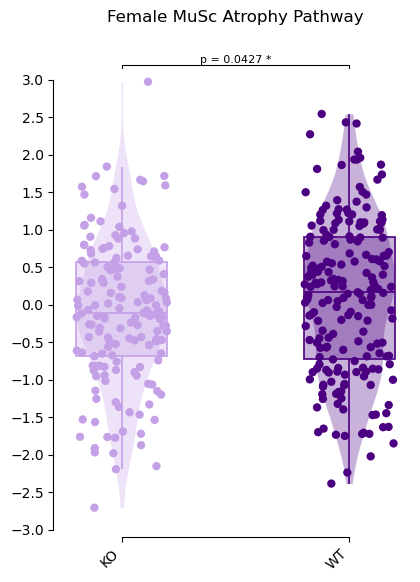

<Figure size 640x480 with 0 Axes>

In [74]:
custom_colors = {
    'KO': '#C4A0E7',      # '#66C2D7' Soft teal blue '#C4A0E7',# Light lavender
    'WT': '#4B0082'   # '#2E86AB' Deeper teal blue, '#4B0082' # Indigo
}

fig = plot_violin_box_combo(
    data=scores,
    x_var='condition',
    y_var='senescence_score',
    title='Female MuSc Atrophy Pathway',
    x_ticks=scores['condition'].unique(),
    palette=custom_colors,
    rotation=45
)

# Display the plot
from IPython.display import display
display(fig)
# save as pdf 
#fig.savefig('/ocean/projects/cis240075p/asachan/datasets/senescence_datasets/mouse_liver/figures/cellage_scores.pdf', bbox_inches='tight')

## Metabolic geneset scores (dotplots)

In [5]:
# load geneset of interest
geneset_gmt = ["/ocean/projects/cis240075p/asachan/datasets/gene_sets/human/metabolism/GOBP_FATTY_ACID_BETA_OXIDATION.v2024.1.Hs.gmt", "/ocean/projects/cis240075p/asachan/datasets/gene_sets/human/metabolism/KEGG_CITRATE_CYCLE_TCA_CYCLE.v2024.1.Hs.gmt", "/ocean/projects/cis240075p/asachan/datasets/gene_sets/human/metabolism/KEGG_GLYCOLYSIS_GLUCONEOGENESIS.v2024.1.Hs.gmt",
               "/ocean/projects/cis240075p/asachan/datasets/gene_sets/human/metabolism/KEGG_OXIDATIVE_PHOSPHORYLATION.v2024.1.Hs.gmt","/ocean/projects/cis240075p/asachan/datasets/gene_sets/human/metabolism/REACTOME_BRANCHED_CHAIN_AMINO_ACID_CATABOLISM.v2024.1.Hs.gmt","/ocean/projects/cis240075p/asachan/datasets/gene_sets/human/metabolism/REACTOME_GLUTAMATE_AND_GLUTAMINE_METABOLISM.v2024.1.Hs.gmt"]

geneset_df = gmt_to_decoupler_multiple_pathways(geneset_gmt, geneset_name='source', genesymbol_name='target')
geneset_df['target'] = convert_genes(geneset_df['target'].tolist(), 'human_to_mouse')
# add atrophy pathway
geneset_df = pd.concat([geneset_df, pd.DataFrame({'source': "Atrophy Pathway (PMID: 31325479)", 'target': custom_atrophy_pathway_mouse})])
# get the number of rows in each unique geneset
geneset_size = geneset_df['source'].value_counts()
display(geneset_size)
display(geneset_df)


source
KEGG_OXIDATIVE_PHOSPHORYLATION                   132
GOBP_FATTY_ACID_BETA_OXIDATION                    75
KEGG_GLYCOLYSIS_GLUCONEOGENESIS                   62
Atrophy Pathway (PMID: 31325479)                  43
KEGG_CITRATE_CYCLE_TCA_CYCLE                      31
REACTOME_BRANCHED_CHAIN_AMINO_ACID_CATABOLISM     21
REACTOME_GLUTAMATE_AND_GLUTAMINE_METABOLISM       14
Name: count, dtype: int64

,source,target
0,GOBP_FATTY_ACID_BETA_OXIDATION,Abcb11
1,GOBP_FATTY_ACID_BETA_OXIDATION,Abcd1
2,GOBP_FATTY_ACID_BETA_OXIDATION,Abcd2
3,GOBP_FATTY_ACID_BETA_OXIDATION,Abcd3
4,GOBP_FATTY_ACID_BETA_OXIDATION,Abcd4
...,...,...
38,Atrophy Pathway (PMID: 31325479),Hdac9
39,Atrophy Pathway (PMID: 31325479),Runx1
40,Atrophy Pathway (PMID: 31325479),Ampd3
41,Atrophy Pathway (PMID: 31325479),Chrna1


In [24]:
%%time
decoupler.mt.aucell(
    adata_male,
    geneset_df,
    raw=False,
    verbose=True
)

2025-11-12 04:48:07 | [INFO] aucell - Running aucell
2025-11-12 04:48:07 | [INFO] Extracted omics mat with 24379 rows (observations) and 1188 columns (features)
2025-11-12 04:48:07 | [WARNING] weight not found in net.columns, adding it as:
net['weight'] = 1
2025-11-12 04:48:07 | [INFO] Network has 33 unique features and 4 unique sources
2025-11-12 04:48:07 | [INFO] aucell - calculating 4 AUCs for 1188 targets across 24379 observations, categorizing features at rank=60


  0%|          | 0/24379 [00:00<?, ?it/s]

2025-11-12 04:48:16 | [INFO] aucell - done


CPU times: user 1min 45s, sys: 3min 31s, total: 5min 16s
Wall time: 9.45 s


In [25]:
metabolic_pathways = [
    "GOBP_FATTY_ACID_BETA_OXIDATION",
    "KEGG_CITRATE_CYCLE_TCA_CYCLE",
    "KEGG_GLYCOLYSIS_GLUCONEOGENESIS",
    "KEGG_OXIDATIVE_PHOSPHORYLATION",
    "REACTOME_BRANCHED_CHAIN_AMINO_ACID_CATABOLISM",
    "REACTOME_GLUTAMATE_AND_GLUTAMINE_METABOLISM"
]
atrophy_pathway = "Atrophy Pathway (PMID: 31325479)"

In [26]:
# add aucell scores to obs
# Combine all pathways
all_pathways = metabolic_pathways + [atrophy_pathway]

# Transfer AUCell scores from obsm to obs
for pathway in all_pathways:
    if pathway in adata_male.obsm["score_aucell"].columns:
        adata_male.obs[pathway] = adata_male.obsm["score_aucell"][pathway]
    else:
        print(f"Warning: {pathway} not found in score_aucell")

In [27]:
#write to file
adata_male.write_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/male_filtered_aucell.h5ad')

In [36]:
# # subset to skeletal muscle stem cells
adata_subset_f = adata_female[adata_female.obs['C_scANVI'] == 'Fast IIB']
# adata_subset_m = adata_male[adata_male.obs['C_scANVI'] == 'Skeleton MuSc']

In [37]:
adata_subset_f

View of AnnData object with n_obs × n_vars = 7361 × 1299
    obs: 'sample_id', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'n_genes', 'sex', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'GOBP_FATTY_ACID_BETA_OXIDATION', 'KEGG_GLYCOLYSIS_GLUCONEOGENESIS', 'KEGG_OXIDATIVE_PHOSPHORYLATION', 'Atrophy Pathway (PMID: 31325479)'
    var: 'hb', 'ribo', 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'varian

In [38]:
# Use cell-level data directly from adata.obs
cell_level_scores_df = adata_subset_f.obs[['sample_id', 'condition', 'C_scANVI','GOBP_FATTY_ACID_BETA_OXIDATION', 'KEGG_GLYCOLYSIS_GLUCONEOGENESIS', 'KEGG_OXIDATIVE_PHOSPHORYLATION', 'Atrophy Pathway (PMID: 31325479)']].copy()
display(cell_level_scores_df)

,sample_id,condition,C_scANVI,GOBP_FATTY_ACID_BETA_OXIDATION,KEGG_GLYCOLYSIS_GLUCONEOGENESIS,KEGG_OXIDATIVE_PHOSPHORYLATION,Atrophy Pathway (PMID: 31325479)
AAACGAAAGGGCCTCT-1,F7_KO,KO,Fast IIB,0.012397,0.000000,0.0,0.185012
AAACGAATCACCTCGT-1,F7_KO,KO,Fast IIB,0.000000,0.000000,0.0,0.121780
AAACGAATCGTAACTG-1,F7_KO,KO,Fast IIB,0.000000,0.006163,0.0,0.000000
AAACGCTAGATCACCT-1,F7_KO,KO,Fast IIB,0.024793,0.000000,0.0,0.081967
AAACGCTAGCATCCCG-1,F7_KO,KO,Fast IIB,0.117769,0.021572,0.0,0.168618
...,...,...,...,...,...,...,...
TGTGAAGGTTAGCACT-1,F4_WT,WT,Fast IIB,0.000000,0.000000,0.0,0.185012
TGTGCATGTTATCGGT-1,F4_WT,WT,Fast IIB,0.000000,0.010786,0.0,0.070258
TGTGCCAGTAGTCAAG-1,F4_WT,WT,Fast IIB,0.099174,0.000000,0.0,0.035129
TGTGGTTGTGAACGCG-1,F4_WT,WT,Fast IIB,0.000000,0.000000,0.0,0.072600


/ocean/projects/cis240075p/asachan/bio_informatics_analysis/TA_muscle_mouse_analysis/snRNA_code/py_scripts/geneset_analysis/utils.py:630: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  violin = sns.violinplot(


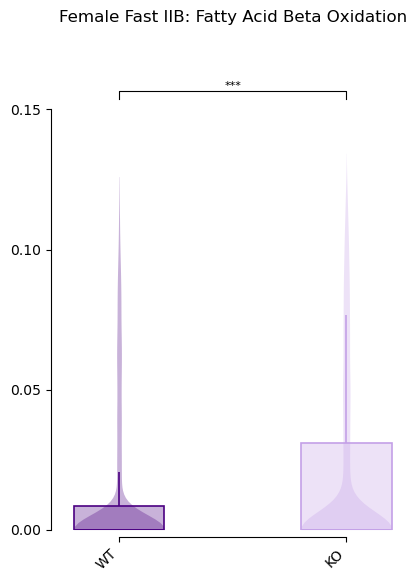

<Figure size 640x480 with 0 Axes>

In [45]:
custom_colors = {
    'KO': '#C4A0E7',      # '#66C2D7' Soft teal blue '#C4A0E7',# Light lavender
    'WT': '#4B0082'   # '#2E86AB' Deeper teal blue, '#4B0082' # Indigo
}
# custom_colors = {
#     'KO': '#66C2D7',      # '#66C2D7' Soft teal blue '#C4A0E7',# Light lavender
#     'WT': '#2E86AB'   # '#2E86AB' Deeper teal blue, '#4B0082' # Indigo
# }

fig = plot_violin_box_combo(
    data=cell_level_scores_df,
    x_var='condition',
    y_var='GOBP_FATTY_ACID_BETA_OXIDATION',
    title='Female Fast IIB: Fatty Acid Beta Oxidation',
    x_ticks=['WT', 'KO'],
    palette=custom_colors,
    rotation=45,
    show_scatter=False
)

# Display the plot
from IPython.display import display
display(fig)

/tmp/ipykernel_78666/3962521567.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = plot_df.groupby(sample_col)


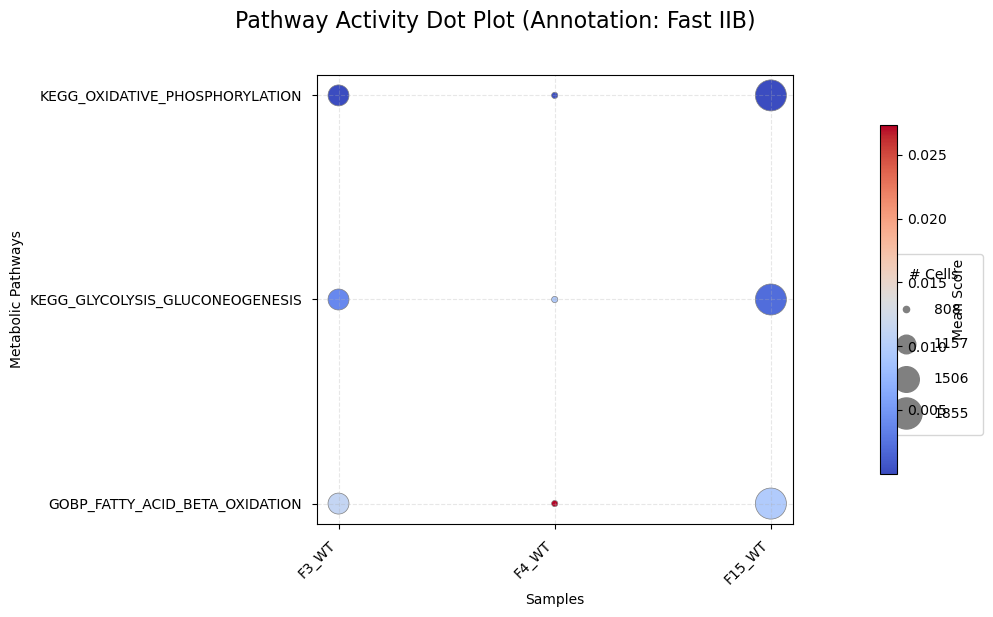

In [41]:
plot_pathway_dotplot(
    cell_level_scores_df,
    score_cols=['GOBP_FATTY_ACID_BETA_OXIDATION', 'KEGG_GLYCOLYSIS_GLUCONEOGENESIS', 'KEGG_OXIDATIVE_PHOSPHORYLATION'],
    sample_col='sample_id',
    sample_order=['F3_WT', 'F4_WT', 'F15_WT'],
    annotation_col='C_scANVI', 
    target_annotation='Fast IIB',
    ylabel="Metabolic Pathways"
)